In [1]:
import os
from os import path
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
from glob import glob
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import *
import torchvision
from generator import GeneratorRRDB
from trainer_org import LitTrainer as LitTrainer_org
from trainer_gan import LitTrainer as LitTrainer_gan
# from trainer_tune import LitTrainer as LitTrainer_tune
import pytorch_lightning as pl
from discriminator import Discriminator
from feature_extractor import FeatureExtractor
from torchvision.utils import save_image
from torchsummary import summary

print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
std = 0.3548

In [35]:
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1)
discriminator = Discriminator(input_shape=(1, 64, 64))
feature_extractor = FeatureExtractor()

In [13]:
summary(generator, input_size=(1, 64, 64), batch_size=32, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 64, 64]             640
         LeakyReLU-2           [32, 64, 64, 64]               0
            Conv2d-3           [32, 64, 64, 64]          36,928
         LeakyReLU-4           [32, 64, 64, 64]               0
            Conv2d-5           [32, 64, 64, 64]          36,928
         LeakyReLU-6           [32, 64, 64, 64]               0
            Conv2d-7           [32, 64, 64, 64]          36,928
         LeakyReLU-8           [32, 64, 64, 64]               0
            Conv2d-9           [32, 64, 64, 64]          73,792
        LeakyReLU-10           [32, 64, 64, 64]               0
           Conv2d-11           [32, 64, 64, 64]         110,656
        LeakyReLU-12           [32, 64, 64, 64]               0
           Conv2d-13           [32, 64, 64, 64]         147,520
        LeakyReLU-14           [32, 64,

In [14]:
test_subjects = data_split('test', patients_frac=1)

test_set = tio.SubjectsDataset(
    test_subjects, transform=Normalize(std=std))

Loading test set...


In [15]:
real_subjects = real_data()

transform = tio.Compose([
    Normalize(std=std),
    # tio.CropOrPad((224,224,45))
])

real_set = tio.SubjectsDataset(
    real_subjects, transform=transform)

Loading real dataset...


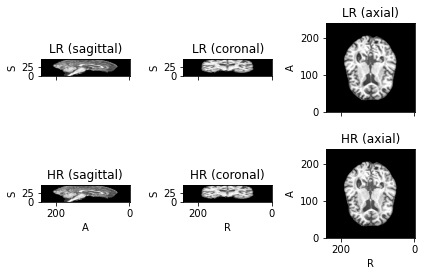

In [16]:
img_real = ImagePair(number=7, simulated=False, select_slices=48)
real_subject = [img_real.subject()]
real_set = tio.SubjectsDataset(
    real_subject, transform=Normalize(std=std))

real_set[0].plot()

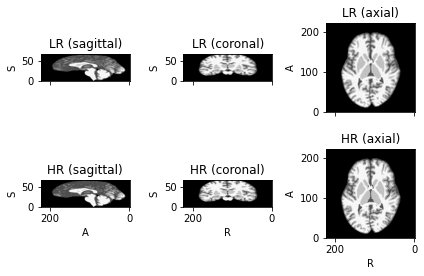

In [16]:
img_sim = ImagePair(number=100206, simulated=True, select_slices=70)
sim_subject = [img_sim.subject()]

sim_set = tio.SubjectsDataset(
    sim_subject, transform=Normalize(std=std))

sim_set[0].plot()

In [46]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

config = {
    'batch_size': 256, # tune.grid_search([32, 256]),
    'num_filters': 64, # tune.grid_search([16, 64]),
    'optimizer': 'adam', # tune.grid_search(['adam', 'sgd']),
}

ckptpath = 'ray_results/var-batchsize/checkpoints'
ckpt_filename = 'checkpoint_{}_{}_{}-best'.format(config['batch_size'], config['num_filters'], config['optimizer']
                                           )

model = LitTrainer_org.load_from_checkpoint(netG=generator,
                                            netF=feature_extractor,
                                            checkpoint_path=os.path.join(ckptpath, ckpt_filename+'.ckpt'))
# model = LitTrainer_gan.load_from_checkpoint(netG=generator,
#                                             netF=feature_extractor,
#                                             netD=discriminator,
#                                             checkpoint_path=os.path.join(ckptpath, ckpt_filename+'.ckpt'))
print(model.hparams)
model.to(device)
model.eval()
model.freeze()

"args":   Namespace(std=0.3548, num_workers=4, root_dir='/mnt/beta/djboonstoppel/Code', name='var-batchsize', num_samples=1, patch_size=64, logger=True, checkpoint_callback=None, enable_checkpointing=True, default_root_dir=None, gradient_clip_val=None, gradient_clip_algorithm=None, process_position=0, num_nodes=1, num_processes=1, devices=None, gpus=None, auto_select_gpus=False, tpu_cores=None, ipus=None, log_gpu_memory=None, progress_bar_refresh_rate=None, enable_progress_bar=True, overfit_batches=0.0, track_grad_norm=-1, check_val_every_n_epoch=1, fast_dev_run=False, accumulate_grad_batches=None, max_epochs=-1, min_epochs=None, max_steps=-1, min_steps=None, max_time='00:12:00:00', limit_train_batches=1.0, limit_val_batches=1.0, limit_test_batches=1.0, limit_predict_batches=1.0, val_check_interval=1.0, flush_logs_every_n_steps=None, log_every_n_steps=50, accelerator=None, strategy=None, sync_batchnorm=False, precision=16, enable_model_summary=True, weights_summary='top', weights_save_

In [47]:
batch_size = model.hparams.config['batch_size']

patch_size = (model.hparams.config['patch_size'],model.hparams.config['patch_size'])
ovl_perc = (model.hparams.config['patch_overlap'], model.hparams.config['patch_overlap'])
overlap, nr_patches = calculate_overlap(test_subjects[0]['LR'], patch_size, ovl_perc)

In [48]:
subject = sim_set[0]
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size=(*patch_size,1),
    # patch_overlap=(36,36,0),
    patch_overlap=overlap,
    padding_mode=0,
)

patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=model.hparams.config['batch_size'])

4.565068960189819


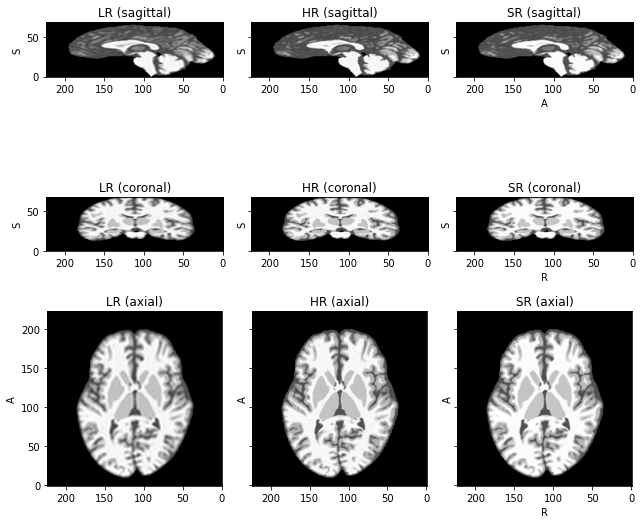

In [49]:
import time

start = time.time()

aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
with torch.no_grad():
    for patches_batch in patch_loader:
        imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
        gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
        locations = patches_batch[tio.LOCATION]
        aggregator.add_batch(gen_hr, locations)

foreground = aggregator.get_output_tensor()
end = time.time()
print(end - start)
torch.cuda.empty_cache()

generated = tio.ScalarImage(tensor=foreground)
subject.add_image(generated, 'SR')
subject.plot(figsize=(9, 8))

In [25]:
def re_scale(img, std, max_val):
    img *= std
    img *= max_val
    return img

def save_to_nifti(img, header, fname, std, max_val):
    affine = np.eye(4)
    affine[2,2] = 2
    img = img.numpy()[0]
    img = re_scale(img, std, max_val)
    img_nifti = nib.Nifti1Image(img, affine=affine, header=header)
    nib.save(img_nifti, fname)

def save_subject(subject, header, pref, std, max_vals, path='output'):
    save_to_nifti(img = subject['LR'],
                  header = header,
                  std = std,
                  max_val = max_vals[0],
                  fname = os.path.join(path, '{}_LR.nii.gz'.format(pref)),
                  )
    save_to_nifti(img = subject['HR'],
                  header = header,
                  std = std,
                  max_val = max_vals[1],
                  fname = os.path.join(path, '{}_HR.nii.gz'.format(pref)),
                  )
    save_to_nifti(img = subject['SR'],
                  header = header,
                  std = std,
                  max_val = max_vals[2],
                  fname = os.path.join(path, '{}_SR.nii.gz'.format(pref)),
                  )

In [50]:
# gen_hr = subject['SR'].numpy()[0]
# gen_hr_nifty = nib.Nifti1Image(gen_hr, affine=img.subject()['HR'].affine, header=img.info()['HR'])
# nib.save(gen_hr_nifty, 'test.nii.gz')

fname ='img_{}_{}_{}'.format(config['batch_size'],
                             config['num_filters'],
                             config['optimizer'])

output_path = 'ray_results/var-batchsize/output'
os.makedirs(output_path, exist_ok=True)
# name='100206'
std = std
max_vals = (
    img_sim.info()['LR']['scaling'],
    img_sim.info()['HR']['scaling'],
    img_sim.info()['LR']['scaling'],
    )
save_subject(subject=subject,
             header=img_sim.info()['LR']['header'],
             pref=fname,
             std=std,
             max_vals=max_vals,
             path=output_path,
             )

In [ ]:
# config = {
#     'learning_rate': 0.0001,
#     'patch_size': 224,
#     'batch_size': 16,
#     'patients_frac': 0.5,
#     'patch_overlap': 0.5,
#     'optimizer': 'adam',
#     'edge_loss': 2,
# }
# ckpt_filename = 'checkpoint_{}_{}_{}_{}_{}_{}'.format(config['patch_size'],
#                                                       config['batch_size'],
#                                                       config['patients_frac'],
#                                                       config['edge_loss'],
#                                                       config['optimizer'],
#                                                       config['learning_rate'],
#                                                       )

config = model.hparams.config
# img_name = 'gen_{}_{}_{}_{}_{}_{}_{}'.format(config['patch_size'],
#                                           config['batch_size'],
#                                           config['patients_frac'],
#                                           config['edge_loss'],
#                                           config['optimizer'],
#                                           # config['learning_rate'],
#                                           config['content'],
#                                           config['adversarial'],
#                                           )

# img_name = 'real_gen_{}'.format(config['patch_size'])
# subject['gen_hr'].save(os.path.join('output', img_name+'_2.dcm'))
# subject['gen_hr'].save(os.path.join('output'))#, img_name+'_2.dcm'))

In [3]:
print(pl.__version__)

1.5.9


In [15]:
import json
dict = {'alpha_content': 0.01,
        'patients_frac': 0.1,
        }

fname = json.dumps(dict)

# fname = "{'alpha_content': 0.01}"
# fname = "{'alpha_content': 0.01, 'patients_frac': 0.1}"

chars = ['"', '{', '}', '. ', '_']

for char in chars:
	fname = fname.replace(char, '')
fname = fname.replace(': ', '_')
fname = fname.replace(', ', '-')
fname = fname.replace('.', ',')



print(fname)

alphacontent_0,01-patientsfrac_0,1


In [11]:
import json
dict = {'alpha_content': 0.01,
        'patients_frac': 0.1,
        }

print(json.dumps(dict))


{"alpha_content": 0.01, "patients_frac": 0.1}


In [38]:
from tensorboard.backend.event_processing import event_accumulator
import cv2

def save_images_from_event(path):
    event_acc = event_accumulator.EventAccumulator(path, size_guidance={'images': 0})
    event_acc.Reload()
    path, fname = os.path.split(path)
    for tag in event_acc.Tags()['images']:
        events = event_acc.Images(tag)
        tag_name = tag.replace('/', ' ')
        tag_path = os.path.join(path, 'images', tag_name)
        os.makedirs(tag_path, exist_ok=True)
        for index, event in enumerate(events):
            s = np.frombuffer(event.encoded_image_string, dtype=np.uint8)
            image = cv2.imdecode(s, cv2.IMREAD_GRAYSCALE)
            fname = '{:04}.jpg'.format(index)
            cv2.imwrite(os.path.join(tag_path, fname), image)

In [39]:
path = '/mnt/beta/djboonstoppel/Code/log/wgan/version_6/events.out.tfevents.1644858303.shire.2157378.0'
save_images_from_event(path)


In [8]:
config = {
    'learning_rate': 1e-4,
    # 'patch_size': args.patch_size,
    # 'batch_size': args.batch_size,
    'patients_frac': 0.5,
    'patch_overlap': 0.5,
    'optimizer': 'adam',
    'edge_loss': 2,
    'b1': 0.9,
    'b2': 0.5,
    'alpha_content': 1,
}

# print ("{:<8} {:<15} {:<10}".format('Name','Age','Percent'))

for key in config:
    # name, age, perc = v
    print ("{:<13}: {:<10} ".format(key, config[key]))

learning_rate: 0.0001     
patients_frac: 0.5        
patch_overlap: 0.5        
optimizer    : adam       
edge_loss    : 2          
b1           : 0.9        
b2           : 0.5        
alpha_content: 1          


In [14]:
with torch.no_grad():
    i = 0
    for patches_batch in patch_loader:
        i += 1
        imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
        if i == 5:
            imgs_lr = imgs_lr[200,0,:,:]*std
            save_image(imgs_lr, 'imgs_lr.png')
            print(imgs_lr.shape)
            np.savetxt('imgs_lr.csv', imgs_lr.numpy(), delimiter=',')
    print(i)
        # gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
        # locations = patches_batch[tio.LOCATION]
        # aggregator.add_batch(gen_hr, locations)

torch.Size([64, 64])
14


In [8]:
config = {
    'ragan': False,
    'learning_rate': 1e-4,
    'patch_size': 64,
    'batch_size': 256,
    'patients_frac': 0.5,
    'patch_overlap': 0.5,
    'optimizer': 'adam',
    'edge_loss': 2,
    'b1': 0.9,
    'b2': 0.5,
    'alpha_content': 1,
}
if config['ragan']:
    print('RaGAN')

In [3]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [6]:
discriminator = Discriminator(input_shape=(3, 256, 256))

summary(discriminator, input_size=(3, 256, 256), batch_size=32, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 256, 256]           1,792
         LeakyReLU-2         [32, 64, 256, 256]               0
            Conv2d-3         [32, 64, 128, 128]          36,928
       BatchNorm2d-4         [32, 64, 128, 128]             128
         LeakyReLU-5         [32, 64, 128, 128]               0
            Conv2d-6        [32, 128, 128, 128]          73,856
       BatchNorm2d-7        [32, 128, 128, 128]             256
         LeakyReLU-8        [32, 128, 128, 128]               0
            Conv2d-9          [32, 128, 64, 64]         147,584
      BatchNorm2d-10          [32, 128, 64, 64]             256
        LeakyReLU-11          [32, 128, 64, 64]               0
           Conv2d-12          [32, 256, 64, 64]         295,168
      BatchNorm2d-13          [32, 256, 64, 64]             512
        LeakyReLU-14          [32, 256,